/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_40308/3506549576.py:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(


Epoch 1/10
111/111 [==============================] - 16s 134ms/step - loss: 0.0130 - val_loss: 0.0067
Epoch 2/10
111/111 [==============================] - 15s 134ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 3/10
111/111 [==============================] - 16s 142ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 4/10
111/111 [==============================] - 16s 142ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 5/10
111/111 [==============================] - 18s 162ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 6/10
111/111 [==============================] - 14s 128ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 7/10
111/111 [==============================] - 15s 138ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/10
111/111 [==============================] - 15s 139ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/10
111/111 [==============================] - 16s 143ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 10/10
111/111 [==============================] - 16s 147ms/step - l

09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


56/56 [==============================] - 2s 31ms/step
Hybrid Model MSE: 13829560160222.3379
Hybrid Model R2: -11363951.1943


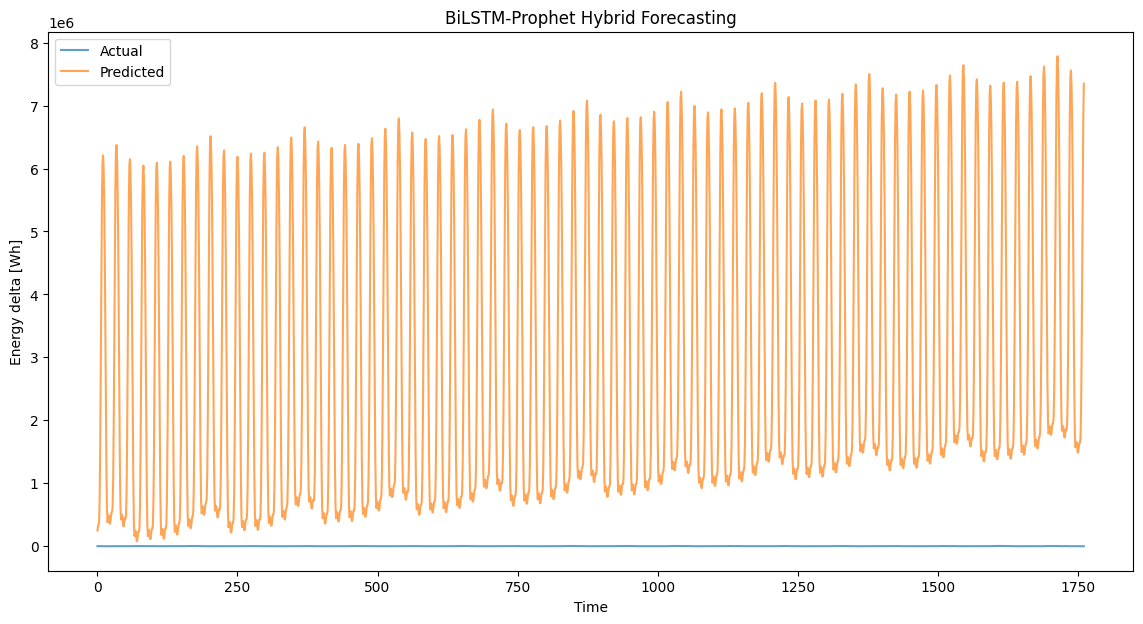

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from prophet import Prophet


# Load the dataset
data = pd.read_csv(
    '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv',
    header=0,
    infer_datetime_format=True,
    parse_dates=['Time'],
    index_col=['Time']
)

# Filter data for specified months and year
data = data[(data.index.month.isin([5, 6, 7])) & (data.index.year == 2021)]
dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]

# Scale the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences with time steps
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# Set time_step and prepare data
time_step = 24  # 24 hours lookback
X, y = create_dataset(scaled_data, time_step)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the BiLSTM model
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(250, return_sequences=True, activation='relu'), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(250, activation='relu')),
        Dropout(0.2),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the BiLSTM model
bilstm_model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))
history = bilstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Forecasting using Prophet
prophet_data = data[['Energy delta[Wh]']].reset_index()
prophet_data.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(prophet_data)

future = prophet_model.make_future_dataframe(periods=len(y_test), freq='H')
forecast = prophet_model.predict(future)

# Combine BiLSTM and Prophet
prophet_predictions = forecast['yhat'][-len(y_test):].values
bilstm_predictions = bilstm_model.predict(X_test).flatten()

# Inverse transform the Prophet and BiLSTM predictions
prophet_predictions_rescaled = scaler.inverse_transform(np.c_[prophet_predictions, np.zeros((len(prophet_predictions), scaled_data.shape[1] - 1))])[:, 0]
bilstm_predictions_rescaled = scaler.inverse_transform(np.c_[bilstm_predictions, np.zeros((len(bilstm_predictions), scaled_data.shape[1] - 1))])[:, 0]

# Final predictions (e.g., weighted average)
alpha = 0.5  # Weight for combining
final_predictions_rescaled = alpha * bilstm_predictions_rescaled + (1 - alpha) * prophet_predictions_rescaled

# Rescale predictions and ground truth
y_test_rescaled = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), scaled_data.shape[1] - 1))])[:, 0]
# final_predictions_rescaled = scaler.inverse_transform(np.c_[final_predictions, np.zeros((len(final_predictions), scaled_data.shape[1] - 1))])[:, 0]

# Evaluate performance
mse = mean_squared_error(y_test_rescaled, final_predictions_rescaled)
r2 = r2_score(y_test_rescaled, final_predictions_rescaled)

print(f"Hybrid Model MSE: {mse:.4f}")
print(f"Hybrid Model R2: {r2:.4f}")

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual', alpha=0.7)
plt.plot(final_predictions_rescaled, label='Predicted', alpha=0.7)
plt.legend()
plt.title('BiLSTM-Prophet Hybrid Forecasting')
plt.xlabel('Time')
plt.ylabel('Energy delta [Wh]')
plt.show()
